In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../utils')
from split_dataset import split_dataframe_by_keys
from dataset_loader import TidySequentialDataCSVLoader
%matplotlib inline

## Load the vitals and demographics

In [2]:
data_dir = 'data/eicu'
ts_csv = os.path.join(data_dir, 'features_per_tstep.csv.gz')
outcomes_csv = os.path.join(data_dir, 'outcomes_per_seq.csv')

ts_df = pd.read_csv(ts_csv)
outcomes_df = pd.read_csv(outcomes_csv)

# keep only outcomes for which any data is observed
outcomes_df = outcomes_df[outcomes_df.icustay_id.isin(ts_df.icustay_id.unique())].copy().reset_index(drop=True)

## Remove stays less than 30 hours

In [ ]:
min_stay_hrs = 30
min_stay_days = min_stay_hrs/24.0
keep_inds = outcomes_df['los_icu']>=min_stay_days
outcomes_df = outcomes_df.loc[keep_inds, :].copy().reset_index(drop=True)
ts_df = ts_df.loc[ts_df['icustay_id'].isin(outcomes_df['icustay_id']), :].reset_index(drop=True)


stay_lengths = outcomes_df['los_icu'].values
n_stays = len(outcomes_df['icustay_id'].unique())
# n_patients = len(outcomes_df['subject_id'].unique())
n_deaths = outcomes_df['mort'].sum()

print('Total stays : %d'%n_stays)
# print('Total patients : %d'%n_patients)
print('Frac of stays resulting in death : %.3f'%(n_deaths/n_stays))
# print('Frac of patients who die : %.3f'%(n_deaths/n_patients))

for min_los in [3, 5, 7]:
    inds = stay_lengths>=min_los
    frac_above_min_los = len(stay_lengths[inds])/n_stays
    print('Frac stays > %d days : %.3f'%(min_los, frac_above_min_los))

## Plot the LOS distribution

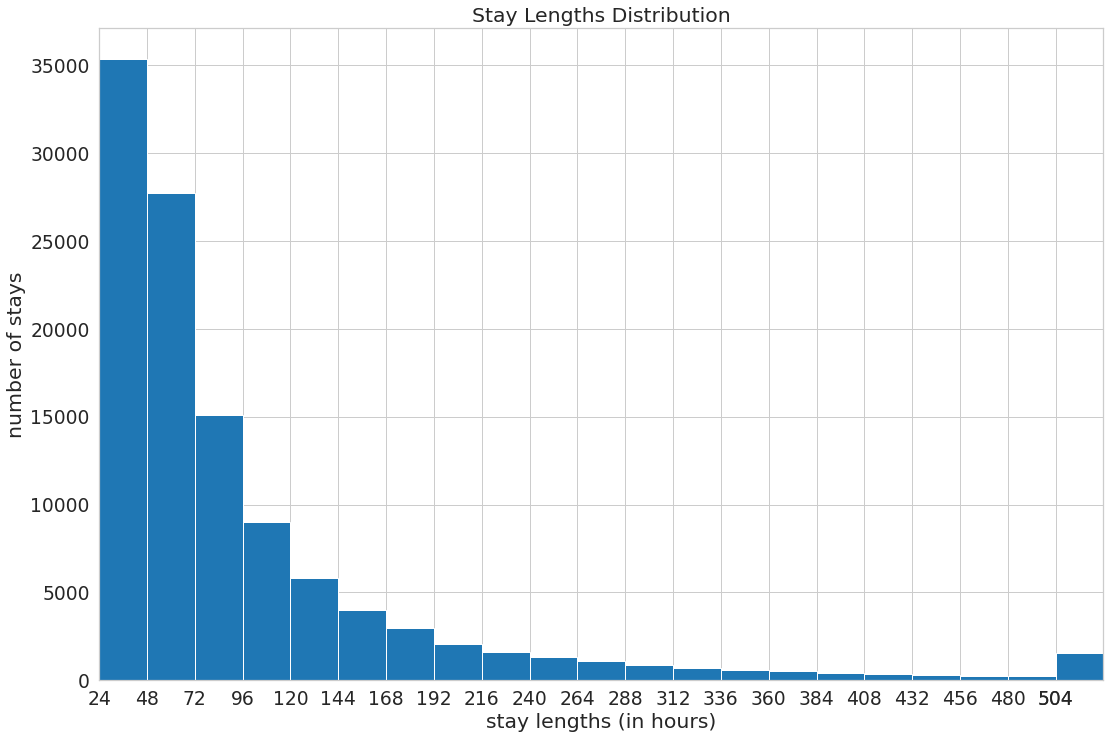

In [9]:
max_los_hrs = outcomes_df['los_icu'].max()*24
min_t = 24
max_t = 504
step = 24
bins = np.arange(24, max_t+1, step)
bins=np.insert(bins, len(bins), max_los_hrs)

f, axs = plt.subplots(1, 1, figsize=(18, 12))
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.7)
x = outcomes_df['los_icu'].values*24.0
axs.hist(x, bins=bins, 
        )
axs.set_xlabel('stay lengths (in hours)')
axs.set_ylabel('number of stays')
axs.set_xlim([min_t, max_t+step])
bins[-1]=max_t
axs.set_xticks(bins)
axs.set_title('Stay Lengths Distribution')
f.savefig('LOS_distribution_EICU.pdf', bbox_inches='tight')
plt.show()

## Get the range of measurements of all features

In [ ]:
ts_feature_cols = ['ALT (SGPT)', 'AST (SGOT)', 'BUN', 'Hct',
       'Hgb', 'MCH', 'PT', 'RBC', 'WBC x 1000', 'albumin', 'anion gap',
       'calcium', 'chloride', 'creatinine', 'glucose', 'platelets x 1000',
       'potassium', 'sodium', 'total bilirubin', 'total protein', 'uric acid',
       'magnesium', 'bedside glucose', 'lactate', 'HCO3', 'pH', 'FiO2',
       'Total CO2', 'fibrinogen', 'CRP', 'phosphate', 'direct bilirubin',
       'troponin - T', 'age', 'gender_is_male']

id_col = ['icustay_id']
id_cols = ['hadm_id', 'icustay_id']
time_col = ['hours_in']

feature_cols = ts_feature_cols
features_df = ts_df[id_cols+time_col+feature_cols].copy()

for lab in feature_cols:
    features_df[lab] = pd.to_numeric(features_df[lab], errors='coerce')

In [12]:
len(ts_feature_cols)

35

In [ ]:
feats_summary_df = pd.DataFrame()
for lab in feature_cols:
    curr_lab_series = features_df[lab]
#     feats_summary_df.loc[lab, 'min'] = curr_lab_series.min()
#     feats_summary_df.loc[lab, 'max'] = curr_lab_series.max()
    feats_summary_df.loc[lab, '10%'] = np.nanpercentile(curr_lab_series, 10)
    feats_summary_df.loc[lab, '90%'] = np.nanpercentile(curr_lab_series, 90)
    feats_summary_df.loc[lab, 'median'] = curr_lab_series.median()


lab_counts_per_stay_df = features_df.groupby(id_col).count()
labs_missing_rate_entire_stay_dict = dict()
for lab in feature_cols:
    labs_missing_rate_entire_stay_dict[lab] = ((lab_counts_per_stay_df[lab]==0).sum())/lab_counts_per_stay_df.shape[0]
labs_missing_rate_entire_stay_series = pd.Series(labs_missing_rate_entire_stay_dict)

feats_summary_df.loc[:,'missing_rate'] = labs_missing_rate_entire_stay_series
feats_summary_df = feats_summary_df[['10%', 'median', '90%', 'missing_rate']]
feats_summary_df.to_csv('ts_feats_summary.csv')
feats_summary_df.round(2)

## Split in train/valid/test

In [66]:
random_state=41
cols_to_group = ['hadm_id', 'icustay_id']
x_train_df, x_test_df = split_dataframe_by_keys(
    features_df, cols_to_group=cols_to_group, size=0.2, random_state=random_state)

x_train_df, x_valid_df = split_dataframe_by_keys(
        x_train_df, cols_to_group=cols_to_group, size=0.2, random_state=random_state) 

y_train_df, y_test_df = split_dataframe_by_keys(
    outcomes_df, cols_to_group=cols_to_group, size=0.2, random_state=random_state)

y_train_df, y_valid_df = split_dataframe_by_keys(
        y_train_df, cols_to_group=cols_to_group, size=0.2, random_state=random_state) 


## Get the train valid test set stats and save data

In [70]:
for split, y_df, x_df in [('train', y_train_df, x_train_df),
                   ('valid', y_valid_df, x_valid_df),
                   ('test', y_test_df, x_test_df)]:

    stay_lengths = y_df['los_icu'].values
    n_stays = len(y_df['icustay_id'].unique())
#     n_patients = len(y_df['subject_id'].unique())
    n_deaths = y_df['mort'].sum()

    print('Total stays : %d'%n_stays)
#     print('Total patients : %d'%n_patients)
    print('Frac of stays resulting in death : %.3f'%(n_deaths/n_stays))
#     print('Frac of patients who die : %.3f'%(n_deaths/n_patients))
    
    
    save_dir = 'data/eicu/ordinal_los_prediction/'
    for min_los in [3, 5, 7]:
        inds = stay_lengths>=min_los
        frac_above_min_los = len(stay_lengths[inds])/n_stays
        print('Frac stays > %d days in %s : %.3f'%(min_los, split, frac_above_min_los))
        y_df['los_geq_%s_days'%min_los] = (stay_lengths>=min_los)*1
    
    
    x_df.to_csv(os.path.join(save_dir, 'x_%s.csv'%split))   
    y_df.to_csv(os.path.join(save_dir, 'y_%s.csv'%split))  

Total stays : 71602
Frac of stays resulting in death : 0.055
Frac stays > 3 days in train : 0.434
Frac stays > 5 days in train : 0.221
Frac stays > 7 days in train : 0.133
Total stays : 17901
Frac of stays resulting in death : 0.058
Frac stays > 3 days in valid : 0.439
Frac stays > 5 days in valid : 0.219
Frac stays > 7 days in valid : 0.131
Total stays : 22376
Frac of stays resulting in death : 0.056
Frac stays > 3 days in test : 0.438
Frac stays > 5 days in test : 0.220
Frac stays > 7 days in test : 0.131


## Save the fully supervised train/valid/test splits as numpy arrays for binary classification

In [ ]:
for min_los in [3, 5, 7]:
    ## Convert from dataframe to numpy array of NxTxD
    train_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_train_df,
        y_csv_path=y_train_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    valid_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_valid_df,
        y_csv_path=y_valid_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_test_df,
        y_csv_path=y_test_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
    valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
    test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)

    N_tr = len(train_x_NTD)
    N_va = len(valid_x_NTD)
    N_te = len(test_x_NTD)

    print('positive label fraction in train : %.3f'%(y_train.sum()/len(y_train)))
    print('positive label fraction in valid : %.3f'%(y_valid.sum()/len(y_valid)))
    print('positive label fraction in test : %.3f'%(y_test.sum()/len(y_test)))
    
    ## save the data
    
    curr_save_dir = os.path.join(save_dir, 'los_geq_%s_days_prediction'%min_los)
    # Check whether the specified path exists or not
    isExist = os.path.exists(curr_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(curr_save_dir)

    # save the data to the respective folder
    print('Saving data to %s'%curr_save_dir)
    np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train)
    print('Done saving train..')
    np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid)
    print('Done saving valid..')
    np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test)
    print('Done saving test..')


## Save binary classification data based on % of labeled sequences

In [ ]:
state_id = 41

for min_los in [3, 5, 7]:
    ## Convert from dataframe to numpy array of NxTxD
    train_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_train_df,
        y_csv_path=y_train_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    valid_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_valid_df,
        y_csv_path=y_valid_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_test_df,
        y_csv_path=y_test_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
    valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
    test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)
    
    ## save the data
    bc_save_dir = os.path.join(save_dir, 'los_geq_%s_days_prediction'%min_los)
    # Check whether the specified path exists or not
    isExist = os.path.exists(bc_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(bc_save_dir)
    
    
    print('-------------------------------------------')
    print('LOS > %s days binary classification'%min_los)
    print('-------------------------------------------')
    
    for ii, perc_labelled in enumerate([1.2, 3.7, 11.1, 33.3, 100]):#3.7, 11.1, 33.3, 100
        curr_save_dir = os.path.join(bc_save_dir, 'percentage_labelled_sequences=%s'%perc_labelled)

        print('---------------------------------------------------------------------------')
        print('CREATING TRAIN/VALID/TEST SPLITS FOR %.3f PERCENT OF SEQUENCES LABELLED'%perc_labelled)
        print('---------------------------------------------------------------------------')
        y_train_ss = y_train.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_tr = int((1-(perc_labelled)/100)*N_tr)
        unlabelled_inds_tr = rnd_state.permutation(N_tr)[:n_unlabelled_tr]
        y_train_ss = y_train_ss.astype(np.float32)
        y_train_ss[unlabelled_inds_tr] = np.nan  
        if perc_labelled!=100:
            print('Excluded inds train: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_tr[0],
                                                                  unlabelled_inds_tr[1],
                                                                  unlabelled_inds_tr[2],
                                                                  unlabelled_inds_tr[-3],
                                                                  unlabelled_inds_tr[-2],
                                                                  unlabelled_inds_tr[-1]))

        y_valid_ss = y_valid.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_va = int((1-(perc_labelled)/100)*N_va)
        unlabelled_inds_va = rnd_state.permutation(N_va)[:n_unlabelled_va]
        y_valid_ss = y_valid_ss.astype(np.float32)
        y_valid_ss[unlabelled_inds_va] = np.nan 
        if perc_labelled!=100:
            print('Excluded inds valid: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_va[0],
                                                              unlabelled_inds_va[1],
                                                              unlabelled_inds_va[2],
                                                              unlabelled_inds_va[-3],
                                                              unlabelled_inds_va[-2],
                                                              unlabelled_inds_va[-1]))

        y_test_ss = y_test.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_te = int((1-(perc_labelled)/100)*N_te)
        unlabelled_inds_te = rnd_state.permutation(N_te)[:n_unlabelled_te]
        y_test_ss = y_test_ss.astype(np.float32)
        y_test_ss[unlabelled_inds_te] = np.nan
        if perc_labelled!=100:
            print('Excluded inds test: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_te[0],
                                                              unlabelled_inds_te[1],
                                                              unlabelled_inds_te[2],
                                                              unlabelled_inds_te[-3],
                                                              unlabelled_inds_te[-2],
                                                              unlabelled_inds_te[-1]))

        # Check whether the specified path exists or not
        isExist = os.path.exists(curr_save_dir)

        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(curr_save_dir)

        # save the data to the respective folder
        print('Saving data to %s'%curr_save_dir)
        np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train_ss)
        print('Done saving train..')
        np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid_ss)
        print('Done saving valid..')
        np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test_ss)
        print('Done saving test..')


        print('---------------------------------------------------------------------------')
        for split, y in [('train', y_train_ss),
                        ('valid', y_valid_ss),
                        ('test', y_test_ss)]:
            frac_pos_labels = np.nansum(y)/(~np.isnan(y)).sum()
            print('fraction positive labels in %s set with %.3f percent of sequences labelled : %.4f'%(split,
                                                                                                       perc_labelled,
                                                                                                       frac_pos_labels))
        print('---------------------------------------------------------------------------')

## Split into train/valid/test for ordinal regression

In [ ]:
y_train_df['los_ordinal_label'] = y_train_df['los_geq_3_days']+y_train_df['los_geq_5_days']+y_train_df['los_geq_7_days']
y_valid_df['los_ordinal_label'] = y_valid_df['los_geq_3_days']+y_valid_df['los_geq_5_days']+y_valid_df['los_geq_7_days']
y_test_df['los_ordinal_label'] = y_test_df['los_geq_3_days']+y_test_df['los_geq_5_days']+y_test_df['los_geq_7_days']


## Convert from dataframe to numpy array of NxTxD
train_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_train_df,
    y_csv_path=y_train_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

valid_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_valid_df,
    y_csv_path=y_valid_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)

N_tr = len(train_x_NTD)
N_va = len(valid_x_NTD)
N_te = len(test_x_NTD)

print('positive label fraction in train : %.3f'%(y_train.sum()/len(y_train)))
print('positive label fraction in valid : %.3f'%(y_valid.sum()/len(y_valid)))
print('positive label fraction in test : %.3f'%(y_test.sum()/len(y_test)))

## save the data
curr_save_dir = os.path.join(save_dir, 'los_prediction_ordinal')
# Check whether the specified path exists or not
isExist = os.path.exists(curr_save_dir)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(curr_save_dir)

    

# save the data to the respective folder
print('Saving data to %s'%curr_save_dir)
np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train)
print('Done saving train..')
np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid)
print('Done saving valid..')
np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test)
print('Done saving test..')


## Save ordinal regression data based on % of labeled sequences

In [ ]:
state_id = 41

los_ordinal_prediction_dir = os.path.join(save_dir, 'los_prediction_ordinal')
for ii, perc_labelled in enumerate([1.2, 3.7, 11.1, 33.3, 100]):#3.7, 11.1, 33.3, 100
    curr_save_dir = os.path.join(los_ordinal_prediction_dir, 'percentage_labelled_sequences=%s'%perc_labelled)
    
    print('---------------------------------------------------------------------------')
    print('CREATING TRAIN/VALID/TEST SPLITS FOR %.3f PERCENT OF SEQUENCES LABELLED'%perc_labelled)
    print('---------------------------------------------------------------------------')
    y_train_ss = y_train.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_tr = int((1-(perc_labelled)/100)*N_tr)
    unlabelled_inds_tr = rnd_state.permutation(N_tr)[:n_unlabelled_tr]
    y_train_ss = y_train_ss.astype(np.float32)
    y_train_ss[unlabelled_inds_tr] = np.nan  
    if perc_labelled!=100:
        print('Excluded inds train: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_tr[0],
                                                              unlabelled_inds_tr[1],
                                                              unlabelled_inds_tr[2],
                                                              unlabelled_inds_tr[-3],
                                                              unlabelled_inds_tr[-2],
                                                              unlabelled_inds_tr[-1]))
    
    y_valid_ss = y_valid.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_va = int((1-(perc_labelled)/100)*N_va)
    unlabelled_inds_va = rnd_state.permutation(N_va)[:n_unlabelled_va]
    y_valid_ss = y_valid_ss.astype(np.float32)
    y_valid_ss[unlabelled_inds_va] = np.nan 
    if perc_labelled!=100:
        print('Excluded inds valid: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_va[0],
                                                          unlabelled_inds_va[1],
                                                          unlabelled_inds_va[2],
                                                          unlabelled_inds_va[-3],
                                                          unlabelled_inds_va[-2],
                                                          unlabelled_inds_va[-1]))

    y_test_ss = y_test.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_te = int((1-(perc_labelled)/100)*N_te)
    unlabelled_inds_te = rnd_state.permutation(N_te)[:n_unlabelled_te]
    y_test_ss = y_test_ss.astype(np.float32)
    y_test_ss[unlabelled_inds_te] = np.nan
    if perc_labelled!=100:
        print('Excluded inds test: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_te[0],
                                                          unlabelled_inds_te[1],
                                                          unlabelled_inds_te[2],
                                                          unlabelled_inds_te[-3],
                                                          unlabelled_inds_te[-2],
                                                          unlabelled_inds_te[-1]))
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(curr_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(curr_save_dir)
    
    # save the data to the respective folder
    print('Saving data to %s'%curr_save_dir)
    np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train_ss)
    print('Done saving train..')
    np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid_ss)
    print('Done saving valid..')
    np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test_ss)
    print('Done saving test..')
    
    
    print('---------------------------------------------------------------------------')
    for split, y in [('train', y_train_ss),
                    ('valid', y_valid_ss),
                    ('test', y_test_ss)]:
        frac_pos_labels = np.nansum(y)/(~np.isnan(y)).sum()
        print('fraction positive labels in %s set with %.3f percent of sequences labelled : %.4f'%(split,
                                                                                                   perc_labelled,
                                                                                                   frac_pos_labels))
    print('---------------------------------------------------------------------------')